## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere

import sfacts as sf

from tqdm import tqdm

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [5]:
species_id = 102506

fit = sf.data.World.load(f'data/zshi.sp-{species_id}.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 0.05

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

Frozen(SortedKeysDict({'strain': 200, 'sample': 9232, 'position': 75942, 'allele': 2}))
<xarray.DataArray 'communities' ()>
array(0.00055164, dtype=float32)
Coordinates:
    species_id  int64 102506
Frozen(SortedKeysDict({'strain': 123, 'sample': 9232, 'position': 75942, 'allele': 2}))


In [6]:
sample_meta = pd.read_table('raw/shi2019s13.tsv').set_index('NCBI Accession Number').reindex(fit.sample).dropna()
sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len)

Continent  Country  Study                
AF         MDG      CM_madagascar            109
           TZA      RampelliS_2015            23
AS         BGD      DavidLA_2015              30
           CHN      ChengpingW_2017           91
                    ChngKR_2016                3
                    HeQ_2017                 117
                    LiJ_2017                 173
                    QinJ_2012                190
                    QinN_2014                210
                    WenC_2017                162
                    YuJ_2015                 120
           ISR      ZeeviD_2015              497
           MNG      LiuW_2016                108
           SGP      ChngKR_2016                7
EU         AUT      FengQ_2015               113
           DEU      CosteaPI_2017              1
                    KarlssonFH_2013            2
                    LomanNJ_2013              33
           DNK      KarlssonFH_2013            2
                    LeChate

In [7]:
fit_dist = fit_genotypes.discretized().pdist()

In [8]:
dedup_thresh = 0.05

fit_dedup_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(fit_dist),
    index=fit_dist.columns.astype(int),
)

In [9]:
fit_genotypes_dedup = sf.Genotypes(fit_genotypes.to_series().unstack('strain').groupby(fit_dedup_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())
fit_communities_dedup = sf.Communities(fit_communities.to_series().unstack('strain').groupby(fit_dedup_clust, axis='columns').sum().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.unstack().to_xarray())
fit_dedup = sf.World.from_combined(fit_genotypes_dedup, fit_communities_dedup)

In [10]:
(fit_genotypes.sizes['strain'], fit_dedup.sizes['strain'])

(123, 119)

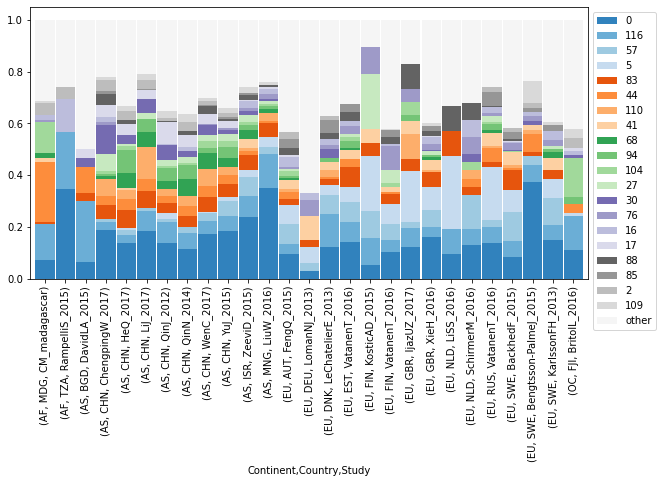

In [21]:
n_top_strains = 20
min_samples = 10

d = fit_dedup.sel(sample=sample_meta.index)

dominant_strain = d.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(n_top_strains).index)

d = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len) > min_samples]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d
    .plot
    .bar(
        width=0.95,
        stacked=True,
        color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

In [17]:
group_thresh = 0.15

fit_group_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=group_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(fit_dist),
    index=fit_dist.columns.astype(int),
)

In [18]:
fit_genotypes_group = sf.Genotypes(fit_dedup.genotypes.to_series().unstack('strain').groupby(fit_group_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())
fit_communities_group = sf.Communities(fit_dedup.communities.to_series().unstack('strain').groupby(fit_group_clust, axis='columns').sum().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.unstack().to_xarray())
fit_group = sf.World.from_combined(fit_genotypes_group, fit_communities_group)

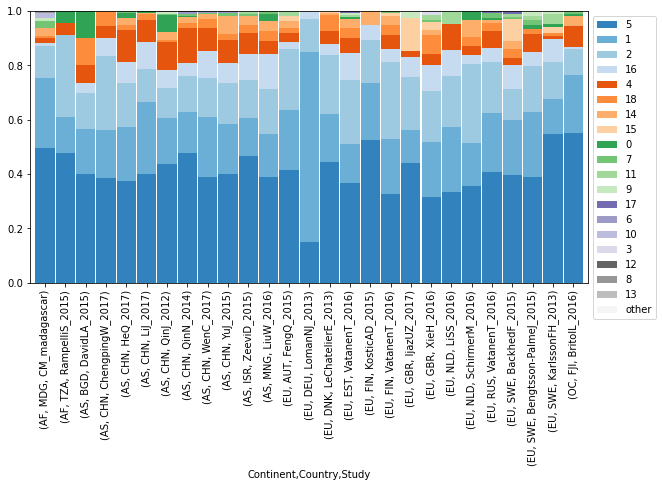

In [20]:
n_top_strains = 20
min_samples = 10

d = fit_group.sel(sample=sample_meta.index)

dominant_strain = d.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(n_top_strains).index)

d = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len) > min_samples]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d
    .plot
    .bar(
        width=0.95,
        stacked=True,
        color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))